# Neural Style Transfer, Part 3

This example uses neural style transfer in order to produce an output image which reproduces content of one image, but the style of another image.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
tf.compat.v1.disable_eager_execution()

from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

In [2]:
def gram_matrix(img):
    # Image shape is [h x c], where c = number of channels
    # This needs to be converted to [c, h*w]
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

    # Calcuate the Gram matrix, G = XX^T / N
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

def style_loss(y, t): 
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(x, fn, epochs, batch_shape):
    '''Search for the solution that minimizes the given function fn
    
    x0 : starting value
    fn : function which is to be minimized
         f, g = func(x, args)
             f : is the value of the function at x
             g : is the gradient of the function at x
    epochs : number of iterations
    batch_shape : shape of the tensor [b, h, w, c], whre b = batch size and c = nr channels
    '''

    losses = []
    
    # Search for the solution
    print('Minimizing the function')
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
                    func = fn,
                    args = batch_shape,
                    x0 = x,
                    maxfun = 20)
        
        # Store the solution
        x = np.clip(x, -127, 127)
        
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)

    plt.plot(losses)
    plt.title('Loss per iteration')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.show()
    
    image = scale_img(unpreprocess(x.reshape(*batch_shape)))[0]

    return image

def VGG16_with_AvgPool(shape):
    '''Loads a pre-trained VGG16 and replaces max pooling by average pooling.
    
    Max pooling is too aggressive at throwing away information, whereas average-pooling
    retains more of the original information.
    '''
    
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

    i = vgg.input
    x = i
    
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)


def VGG16_AvgPool_CutOff(shape, num_convs):
    '''Loads a pre-trained VGG16 with average-pooling, and limits the number of
    convolutional layers.
    '''
    
    if num_convs < 1 or num_convs > 13:
        print('Number of convolutions must be in the range [1, 13]')
        return None
    
    vgg = VGG16_with_AvgPool(shape)
    
    n = 0
    output = None
    
    for layer in vgg.layers:
        if layer.__class__ == Conv2D:
            n += 1
        if n >= num_convs:
            output = layer.output
            break
            
    return Model(vgg.input, output)
            

def unpreprocess(img):
    '''Removes VGG16 preprocessing from the given image.
    '''
    
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    
    return img

def scale_img(x):
    '''Scales the image between [0...1].
    '''
    
    x = x - x.min()
    x = x / x.max()
    
    return x

def load_image_preprocess(path, shape=None):
    
    img = image.load_img(path, target_size=shape)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return img

def load_image(path, shape=None):
    
    img = image.load_img(path, target_size=shape)
    
    return img 

In [3]:
content_img_path = './large_files/picasso.jpg'
style_img_path = './large_files/picasso-weeping-woman.jpg'

content_img = load_image_preprocess(content_img_path)
h, w = content_img.shape[1:3]
style_img = load_image_preprocess(style_img_path, (h, w))

batch_shape = content_img.shape
shape = batch_shape[1:]

print(f'Shape with the batch size included: {batch_shape}')
print(f'Shape without the batch size: {shape}')

Shape with the batch size included: (1, 500, 334, 3)
Shape without the batch size: (500, 334, 3)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 500, 334, 3), dtype=float32)
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 500, 334, 3), dtype=float32)


/home/jarno/miniconda3/envs/tensorflow2-gpu/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 500, 334, 3), dtype=float32)
Minimizing the function
iter=0, loss=89414.6953125
iter=1, loss=32690.865234375
iter=2, loss=24598.287109375
iter=3, loss=21012.7265625
iter=4, loss=18915.03125
iter=5, loss=17679.75390625
iter=6, loss=16818.91015625
iter=7, loss=16203.669921875
iter=8, loss=15748.611328125
iter=9, loss=15369.9013671875
iter=10, loss=15054.6005859375
iter=11, loss=14786.205078125
iter=12, loss=14551.3505859375
iter=13, loss=14343.8115234375
iter=14, loss=14151.0517578125


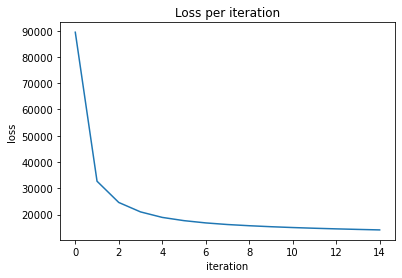

In [4]:
vgg = VGG16_with_AvgPool(shape)

content_model = Model(vgg.input, vgg.layers[12].get_output_at(0))
content_target = K.variable(content_model.predict(content_img))

symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

style_model = Model(vgg.input, symbolic_conv_outputs)

style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

style_weights = [1, 2, 3, 4, 5]

loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  loss += w * style_loss(symbolic[0], actual[0])

grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

def get_loss_and_grads_wrapper(x_vec, *batch_shape):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

x0 = np.random.randn(np.prod(batch_shape))
neural_style_image = minimize(x0, get_loss_and_grads_wrapper, 15, batch_shape)

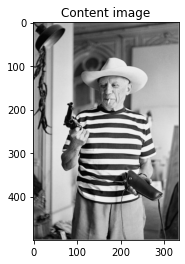

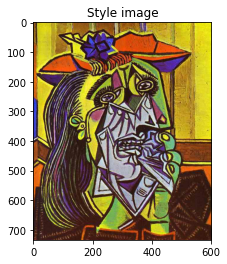

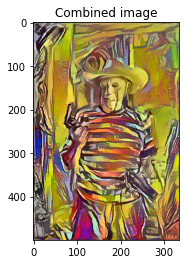

In [5]:
content_image = load_image(content_img_path)
style_image = load_image(style_img_path)

plt.imshow(content_image)
plt.title('Content image')
plt.show()

plt.imshow(style_image)
plt.title('Style image')
plt.show()

plt.imshow(neural_style_image)
plt.title('Combined image')
plt.show()